# __A brief analysis of correlation between salary and factors that possibly affect it:__

__Целями работы являются:__
 * Узнать, от каких параметров и насколько зависит заработная плата IT-специалистов
 * Ответить на вопросы: 
 > Сколько лет опыта необходимо, чтобы получить ту или иную позицию?
 > В каких отраслях платят больше?
 > В каком возрасте наиболее высокий шанс получить работу?
 > насколько сильно компании поддерживают сотрудников при Covid-19?
 * Сделать предсказание заработной платы на основе нескольких объёмных датасетов для корректной оценки персонала

 __Для этих целей было необходимо:__
 * Почистить датасеты от полей с пропущенными/нерелевантными значениями, по возможности заменяя предсказанными значениями исходя из других параметров
 * Объединить датасеты с зарплатами
 * Построить и обучить модель на готовых данных 

Импортируем библиотеки:

In [245]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import catboost as cb
import seaborn as sns
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import OneHotEncoder 
from sklearn.impute import IterativeImputer
from matplotlib import cm
from dash import Dash, html
from tidypython import *
from catboost import CatBoostRegressor
from skimpy import clean_columns

Считываем и предварительно изучаем основные параметры датасетов:

In [246]:
df2020 = pd.read_csv('IT Salary Survey EU_2020.csv')
df2018 = pd.read_csv('IT Salary Survey EU 2018.csv')
df2019 = pd.read_csv('T Salary Survey EU 2019.csv')
df2018.info()
df2019.info()
df2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765 entries, 0 to 764
Data columns (total 14 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Timestamp                           765 non-null    object 
 1   Age                                 672 non-null    float64
 2   Gender                              751 non-null    object 
 3   City                                736 non-null    object 
 4   Position                            737 non-null    object 
 5   Years of experience                 732 non-null    float64
 6   Your level                          743 non-null    object 
 7   Current Salary                      750 non-null    float64
 8   Salary one year ago                 596 non-null    float64
 9   Salary two years ago                463 non-null    float64
 10  Are you getting any Stock Options?  742 non-null    object 
 11  Main language at work               750 non-n

In [247]:
df2020['Company type'].unique()

array(['Product', 'Startup', 'Consulting / Agency', nan, 'Media',
       'Personal Ltd', 'Cloud', 'Behörde', 'Construction',
       'Big commercial', 'Outsorce', 'Bank ', 'Fintech', 'Automotive',
       'Bank', 'IT Department of established business',
       'Telecommunications', 'E-commerce', 'Systemhaus', 'University',
       'consumer goods', 'IT-Outsourcing', 'Game Company', 'Financial ',
       'Corporation', 'Publishing and Technology', 'Market Research ',
       'e-commerce', 'SaaS', 'Publisher', 'Energy ', 'Enterprise',
       'Bloody enterprise', 'service', 'Concern', 'Utilities',
       'Insurance', 'Science Institute ', 'Research institute', 'Retail',
       'Ecommerce', 'E-Commerce', 'Semiconductor', 'Automotive ',
       'Institute', 'Finance', 'Handel ', 'Consulting and Product',
       'Education', 'Pharma',
       'Full-time position in Education, part-time position in at a data startup',
       'Corporation ', 'Transport & Logistics', 'Biergarten ',
       'Non-tech re

Напишем несколько функций, которые пригодятся на протяжении всего проекта:

In [248]:
def cleand(src_df):

    if 'Yearly stocks' in src_df.columns:
        cleand = src_df.assign(net_salary=lambda x: x['Yearly brutto salary (without bonus and stocks)'] + x['Yearly bonus'] + x['Yearly stocks'])
    elif 'Yearly bonus + stocks in EUR' in src_df.columns:
        src_df['Yearly bonus + stocks in EUR'] = pd.to_numeric(src_df['Yearly bonus + stocks in EUR'], errors='coerce').astype(float)
        cleand = src_df.assign(net_salary=lambda x: x['Yearly brutto salary (without bonus and stocks) in EUR'] + x['Yearly bonus + stocks in EUR'])
    else:
        cleand = src_df.drop('Are you getting any Stock Options?', axis=1)
    
    return cleand     

def cleand_last_yr(src_df):

    if 'Yearly brutto salary (without bonus and stocks) one year ago. Only answer if staying in same country' in src_df.columns:
        cleand_last_yr = src_df.assign(salary_last_year=lambda x: x['Yearly brutto salary (without bonus and stocks) one year ago. Only answer if staying in same country'] + x['Yearly bonus one year ago. Only answer if staying in same country'] + x['Yearly bonus one year ago. Only answer if staying in same country'])
    elif 'Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country' in src_df.columns:
        src_df['Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country'] = pd.to_numeric(src_df['Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country'], errors='coerce').astype(float)
        src_df['Annual bonus+stocks one year ago. Only answer if staying in same country'] = pd.to_numeric(src_df['Annual bonus+stocks one year ago. Only answer if staying in same country'], errors='coerce').astype(float)
        cleand_last_yr = src_df.assign(salary_last_year=lambda x: x['Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country'] + x['Annual bonus+stocks one year ago. Only answer if staying in same country'])
    else:
        cleand_last_yr = src_df.drop(['Salary two years ago'],
                                    axis=1)
    return cleand_last_yr   

def trunc_nan(src_df):
    truncated = src_df.apply(lambda x: pd.Series(x.dropna().values))
    truncated = src_df.fillna(0)
    return truncated

def clean_colum(src_df):
    src_df = clean_columns(src_df, case='snake', replace={
        'Are you getting any Stock Options?':'Stocks',
        'Zeitstempel':'Timestamp',
        'Your level':'Seniority level',
        'Position (without seniority)':'Position',
        'Total years of experience':'Years of experience',
        'Main language at work':'Main language',
        'Years of experience': 'experience',
        'Other technologies/programming languages you use often': 'Other technologies',
        'Have you lost your job due to the coronavirus outbreak?' : 'Covid job loss'})
    return src_df


Необходимо почистиь датасеты от малорелевантных значений 

In [249]:

df2019.drop([
            'Number of vacation days',
            'Company name ',
            'Сontract duration',
            '0'],
            axis=1, inplace=True)

df2020.drop([
            'Employment status',
            'Years of experience in Germany',
            'Number of vacation days',
            'Сontract duration',
            'Have you been forced to have a shorter working week (Kurzarbeit)? If yes, how many hours per week',
            'Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR'],
            axis=1, inplace=True)

Исправляем ошибки и подозрительные значения в 'бонусах и ценных бумагах'

In [250]:
current_feature = 'Yearly bonus + stocks in EUR'
print(df2020[current_feature].value_counts().index.tolist())

['0', '5000', '10000', '2000', '6000', '1000', '3000', '20000', '4000', '15000', '7000', '8000', '70000', '75000', '12000', '101', '30000', '100000', '1500', '40000', '60000', '25000', '80000', '50000', '65000', '55000', '200000', '45000', '120000', '500', '7500', '18000', '11000', '35000', '9000', '77000', '95000', '90000', '150000', '17000', '85000', '62000', '73000', '4500', '72000', '15900', '56000', '6500', '13000', '14000', '800', '2500', '16000', '78000', '99000', '66500', '5000000000', '43000', 'depends', '16320', '106000', '71000', '87250', '21000', '6710', '700', '23000', '4400', '3600', '105000', '84000', '97000', '1100', '15000+-', '37968', '1250', 'Na', '110000', 'Not sure', '92000', '45500', '25', '63000', '31500', '28000', '3800', '7200', '80400', '125000', '-', '12500', '7100', '60847.32', '107000', '2800', '36000', '82500', '53500', '66447', '9450', '82000', '170000', '58000', '54000', '1200', '3250', '3375', 'bvg only', '102600', '89000', '5600', '122.13', '400', '460

In [251]:
df2020[current_feature].loc[df2020[current_feature]=='bvg only'] = -1
df2020[current_feature].loc[df2020[current_feature]=='-'] = -1
df2020[current_feature].loc[df2020[current_feature]=='-'] = -1
df2020[current_feature].loc[df2020[current_feature]=='15000+-'] = 15000
df2020[current_feature].loc[df2020[current_feature]=='Not sure'] = -1
df2020[current_feature].loc[df2020[current_feature]=='Na'] = -1
df2020[current_feature].loc[df2020[current_feature]=='depends'] = -1
df2020[current_feature].loc[df2020[current_feature]=='1150000'] = -1 

C:\Users\динара\AppData\Local\Temp\ipykernel_24796\424829876.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2020[current_feature].loc[df2020[current_feature]=='bvg only'] = -1


Убираем совсем редкие случаи в колонке уровня специалиста, меняем нерелевантные

In [252]:
current_feature = 'Seniority level'
print('ORIGINAL:', current_feature)
temp_count = df2020[current_feature].value_counts()
print(temp_count)

positions = {
    'Principal':'Lead',
    'Intern':'Junior',
    'Entry level':'Junior',
    'Working Student':'Junior',
    'C-Level':'Lead',
    'Director':'Lead',
    'C-level executive manager':'Lead',
    'VP':'Lead',
    'Manager':'Lead',
    'CTO':'Lead',
    'intern':'Junior',
    'Student':'Junior',
    'Key':'Lead',
    'student':'Junior',
    'Head':'Lead',
    'No level ':'No level',
    'Self employed':'No level',
    'no idea, there are no ranges in the firm ':'No level',
    'Work Center Manager':'Senior'
}

for pos in positions:
    df2020['Seniority level'] = df2020['Seniority level'].apply(lambda x:positions.get(pos) if (x==pos) else x )


freq_min = 1
keep_levels = list(temp_count[temp_count.values>=freq_min].index)
print('\nREDUCED TO:')
print(df2020[current_feature].value_counts())


ORIGINAL: Seniority level
Senior                                       565
Middle                                       366
Lead                                         166
Junior                                        79
Head                                          44
Principal                                      3
student                                        1
Intern                                         1
Entry level                                    1
Working Student                                1
C-Level                                        1
no idea, there are no ranges in the firm       1
Student                                        1
intern                                         1
Key                                            1
C-level executive manager                      1
Director                                       1
No level                                       1
CTO                                            1
Work Center Manager                        

В данных 2020 года уменьшаю количество уникальных ответов, приравнивая некоторые к 'да' или 'нет'

In [253]:
current_feature = 'Have you lost your job due to the coronavirus outbreak?'
print('ORIGINAL:', current_feature)
temp_count = df2020[current_feature].value_counts()
print(temp_count)
df2020[current_feature].loc[df2020[current_feature]=='Lost the job but for different reason'] = 'No'
df2020[current_feature].loc[df2020[current_feature]=="i didn't but will be looking for new one because of covid"] = 'No'

freq_min = 1
keep_levels = list(temp_count[temp_count.values>=freq_min].index)
df2020[current_feature] = df2020[current_feature].where(df2020[current_feature].isin(keep_levels), 'other')
print('\nREDUCED TO:')
print(df2020[current_feature].value_counts())

ORIGINAL: Have you lost your job due to the coronavirus outbreak?
No                                                                                        1162
Yes                                                                                         63
i didn't but will be looking for new one because of covid                                    1
kurzarbeitzeit for 1.5 months                                                                1
Have been a freelancer at the beginning of year                                              1
No, but there was a salary cut at 10% for 3 months and then at 5% for further 3 months       1
Lost the job but for different reason                                                        1
Leads and project inquiries have slowed down                                                 1
Laid off for a bit                                                                           1
yes but found a new one with better pay / perks                                

C:\Users\динара\AppData\Local\Temp\ipykernel_24796\494251030.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2020[current_feature].loc[df2020[current_feature]=='Lost the job but for different reason'] = 'No'


In [254]:
current_feature = 'Position '
print('ORIGINAL:', current_feature)
temp_count = df2020[current_feature].value_counts()
print(temp_count)
df2020['Position '].to_csv('D:\proG\proggg\position', index=False)

df2020[current_feature].loc[df2020[current_feature]=='Testautomation'] = 'QA Engineer'
df2020[current_feature].loc[df2020[current_feature]=='Senior Network&Security Eng.'] = 'Sequrity Engineer'
df2020[current_feature].loc[df2020[current_feature]=='Big Data Engineer'] = 'Data Engineer'
df2020[current_feature].loc[df2020[current_feature]=='Systemadministrator'] = 'System Administrator'
df2020[current_feature].loc[df2020[current_feature]=='Software Developer in Test'] = 'Software Developer'
df2020[current_feature].loc[df2020[current_feature]=='DB developer/Data analyst'] = 'Data Analyst'
df2020[current_feature].loc[df2020[current_feature]=='SW Architect'] = 'Architect'
df2020[current_feature].loc[df2020[current_feature]=='Fullstack engineer, ну или Software engineer'] = 'Software Engineer'
df2020[current_feature].loc[df2020[current_feature]=='Senior Program Manager'] = 'Project Manager'
df2020[current_feature].loc[df2020[current_feature]=='IT Operations Manager'] = 'Project Manager'
df2020[current_feature].loc[df2020[current_feature]=='Testmanager'] = 'QA Engineer'
df2020[current_feature].loc[df2020[current_feature]=='QA Lead'] = 'QA Engineer'

freq_min = 3      
print('\nREDUCED TO:')
print(df2020[current_feature].value_counts())

ORIGINAL: Position 
Software Engineer            387
Backend Developer            174
Data Scientist               110
Frontend Developer            89
QA Engineer                   71
                            ... 
Testautomation                 1
Recruiter                      1
DBA                            1
DB developer/Data analyst      1
IT Operations Manager          1
Name: Position , Length: 148, dtype: int64

REDUCED TO:
Software Engineer                         388
Backend Developer                         174
Data Scientist                            110
Frontend Developer                         89
QA Engineer                                74
                                         ... 
SAP Developer                               1
Recruiter                                   1
DBA                                         1
Stuttgart                                   1
Researcher/ Consumer Insights Analyst       1
Name: Position , Length: 138, dtype: int64


<>:5: DeprecationWarning: invalid escape sequence '\p'
C:\Users\динара\AppData\Local\Temp\ipykernel_24796\2438073455.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2020[current_feature].loc[df2020[current_feature]=='Testautomation'] = 'QA Engineer'


In [255]:
current_feature = 'Seniority level'
print('ORIGINAL:', current_feature)
temp_count = df2019[current_feature].value_counts()
print(temp_count)

df2019[current_feature].loc[df2019[current_feature]=='Head'] = 'Lead'
df2019[current_feature].loc[df2019[current_feature]=='Principal'] = 'Lead'
print('\nCHANGED TO:')
print(df2019[current_feature].value_counts())

ORIGINAL: Seniority level
Senior       587
Middle       272
Junior        73
Lead          35
Head           6
Principal      3
Name: Seniority level, dtype: int64

CHANGED TO:
Senior    587
Middle    272
Junior     73
Lead       44
Name: Seniority level, dtype: int64


C:\Users\динара\AppData\Local\Temp\ipykernel_24796\1817962411.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2019[current_feature].loc[df2019[current_feature]=='Head'] = 'Lead'


In [256]:
current_feature = 'Position (without seniority)'
print('ORIGINAL:', current_feature)
temp_count = df2019[current_feature].value_counts()
print(temp_count)

df2019[current_feature].loc[df2019[current_feature]=='Head of AI'] = 'Machine Learning Engineer'
df2019[current_feature].loc[df2019[current_feature]=='Data Analyst'] = 'Data Engineer'
df2019[current_feature].loc[df2019[current_feature]=='UX Researcher'] = 'Researcher'
df2019[current_feature].loc[df2019[current_feature]=='Security Engineer'] = 'IT Security'
df2019[current_feature].loc[df2019[current_feature]=='Product manager'] = 'Manager'
df2019[current_feature].loc[df2019[current_feature]=='NLP Engineer'] = 'Data Scientist'
df2019[current_feature].loc[df2019[current_feature]=='Tech Lead'] = 'CTO (CEO, CFO)'
df2019[current_feature].loc[df2019[current_feature]=='Head of Engineering'] = 'CTO (CEO, CFO)'
df2019[current_feature].loc[df2019[current_feature]=='technical business analyst'] = 'Business Analyst'
df2019[current_feature].loc[df2019[current_feature]=='Student, Software Developer, Data Engineer'] = 'Software Developer'
df2019[current_feature].loc[df2019[current_feature]=='DatabEngineer'] = 'Data Engineer'
df2019[current_feature].loc[df2019[current_feature]=='Lead Developer'] = 'Software Developer'
df2019[current_feature].loc[df2019[current_feature]=='QA Manager'] = 'QA'

freq_min = 3
keep_levels = list(temp_count[temp_count.values>=freq_min].index)
df2019[current_feature] = df2019[current_feature].where(df2019[current_feature].isin(keep_levels), 'other')
print('\nREDUCED TO:')
print(df2019[current_feature].value_counts())

ORIGINAL: Position (without seniority)
Backend Developer                253
Data Scientist                   122
Fullstack Developer               78
Frontend Developer                68
Manager                           63
QA                                56
DevOps                            53
Mobile Developer                  46
Data Engineer                     39
Software Architect                36
Machine Learning Engineer         33
Business Analyst                  17
Embedded Developer                14
Researcher                        12
SAP Consultant                    10
SRE                               10
Product Manager                    9
System Administrator               7
Software Engineer                  7
CTO (CEO, CFO)                     7
Cloud Platform Engineer            5
Support                            4
Designer (UI, UX)                  4
Database Developer (DBA)           3
Network Engineer                   3
Tech Lead                          3

C:\Users\динара\AppData\Local\Temp\ipykernel_24796\2159644917.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2019[current_feature].loc[df2019[current_feature]=='Head of AI'] = 'Machine Learning Engineer'


In [257]:
current_feature = 'Position'
print('ORIGINAL:', current_feature)
temp_count = df2018[current_feature].value_counts()
print(temp_count)

df2018[current_feature].loc[df2018[current_feature]=='QA Ingenieur'] = 'QA Engineer'
df2018[current_feature].loc[df2018[current_feature]=='Software engineer ( React/React-native )'] = 'Software Engineer'
df2018[current_feature].loc[df2018[current_feature]=='Project Manager '] = 'Project manager'
df2018[current_feature].loc[df2018[current_feature]=='Pm '] = 'Project manager'
df2018[current_feature].loc[df2018[current_feature]=='Softwareentwickler'] = 'Sowtware developer'
df2018[current_feature].loc[df2018[current_feature]=='Developer'] = 'Software Developer'
df2018[current_feature].loc[df2018[current_feature]=='Software Tester'] = 'QA'
df2018[current_feature].loc[df2018[current_feature]=='Principal Software Engineer'] = 'Software Engineer'

df2018[current_feature].loc[df2018[current_feature]=='Senior Data Scientist'] = 'Data Scientist'
df2018[current_feature].loc[df2018[current_feature]=='Softwaredeveloper'] = 'Software Developer'
df2018[current_feature].loc[df2018[current_feature]=='Senior Software Developer'] = 'Software Developer'
df2018[current_feature].loc[df2018[current_feature]=='Sr project manager'] = 'Project manager'
df2018[current_feature].loc[df2018[current_feature]=='Softwareentwickler'] = 'Sowtware developer'
df2018[current_feature].loc[df2018[current_feature]=='Developer'] = 'Software Developer'
df2018[current_feature].loc[df2018[current_feature]=='Software Tester'] = 'QA'
df2018[current_feature].loc[df2018[current_feature]=='Principal Software Engineer'] = 'Software Engineer'


#freq_min = 2
#keep_levels = list(temp_count[temp_count.values>=freq_min].index)
#df2018[current_feature] = df2018[current_feature].where(df2018[current_feature].isin(keep_levels), 'other')
print('\nREDUCED TO:')
print(df2018[current_feature].value_counts())

ORIGINAL: Position
Java Developer              34
Software Engineer           29
Senior Software Engineer    16
QA                          15
Software Developer          13
                            ..
Java script                  1
TA Engineer                  1
QA Consultant                1
Senior Sys Admin             1
Pm                           1
Name: Position, Length: 397, dtype: int64

REDUCED TO:
Java Developer              34
Software Engineer           32
Software Developer          24
QA                          20
Senior Software Engineer    16
                            ..
ERP/BI Specialist            1
IOS developer                1
SEM Manager                  1
Systems Administrator        1
Oracle Pl/SQL Developer      1
Name: Position, Length: 386, dtype: int64


C:\Users\динара\AppData\Local\Temp\ipykernel_24796\2532333707.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2018[current_feature].loc[df2018[current_feature]=='QA Ingenieur'] = 'QA Engineer'


In [258]:
s = cleand(df2019)
a = clean_colum(s)
cleaneddf_2019 = trunc_nan(a)
cleaneddf_2019.tail(20)

19 column names have been cleaned

,timestamp,age,gender,city,seniority_level,position_without_seniority,experience,your_main_technology_programming_language,yearly_brutto_salary_without_bonus_and_stocks,yearly_bonus,yearly_stocks,yearly_brutto_salary_without_bonus_and_stocks_one_year_ago_only_answer_if_staying_in_same_country,yearly_bonus_one_year_ago_only_answer_if_staying_in_same_country,yearly_stocks_one_year_ago_only_answer_if_staying_in_same_country,number_of_home_office_days_per_month,main_language,company_size,company_type,company_business_sector,net_salary
971,01.01.2020 16:52:48,0.0,Male,Berlin,Senior,Backend Developer,7,Java,70000.0,0.0,0.0,68000.0,0.0,0.0,4.0,Deutsch,100-1000,Consulting / Agency,IT,70000.0
972,02.01.2020 08:48:00,34.0,Male,Cologne,Senior,other,13,C/C++,70000.0,0.0,0.0,57000.0,0.0,0.0,0.0,English,50-100,Product,Manufacture,0.0
973,02.01.2020 14:56:25,29.0,Male,Berlin,Middle,QA,7,Not Relevant,42000.0,3000.0,0.0,0.0,0.0,0.0,4.0,English,100-1000,Consulting / Agency,0,0.0
974,02.01.2020 20:21:33,33.0,Female,Berlin,Junior,Business Analyst,1,PostgreSQL,32000.0,0.0,0.0,0.0,0.0,0.0,2.0,English,1000+,Startup,Finance / Insurance,32000.0
975,03.01.2020 09:54:07,31.0,Male,Munich,0,DevOps,8,AWS,80000.0,0.0,0.0,0.0,0.0,0.0,0.0,English,0,0,0,0.0
976,03.01.2020 11:40:59,37.0,Male,Utrecht,Middle,Manager,17,Java,71000.0,0.0,0.0,71000.0,0.0,0.0,0.0,English,100-1000,Product,Finance / Insurance,71000.0
977,03.01.2020 15:01:40,26.0,Female,Amsterdam,Middle,Backend Developer,4,Java,52800.0,0.0,0.0,0.0,0.0,0.0,4.0,English,1000+,Bank,Finance / Insurance,0.0
978,03.01.2020 19:02:44,33.0,Male,Amsterdam,Senior,Frontend Developer,10,Javascript / Typescript,87000.0,0.0,50000.0,0.0,0.0,0.0,5.0,English,1000+,Product,Сommerce,0.0
979,04.01.2020 14:45:55,28.0,Male,Moscow,Lead,Frontend Developer,5,Javascript / Typescript,54000.0,10000.0,0.0,33600.0,8000.0,0.0,365.0,Russian,100-1000,Product,Security,64000.0
980,04.01.2020 15:50:54,27.0,Male,Berlin,Senior,Data Scientist,5,SAS,73300.0,1500.0,0.0,67100.0,2000.0,0.0,0.0,English,1000+,Consulting / Agency,Health,0.0


In [259]:
b = cleand(df2018)
n = clean_colum(b)
cleaneddf_2018 = trunc_nan(n)
cleaneddf_2018.describe()

13 column names have been cleaned

,age,experience,current_salary,salary_one_year_ago,salary_two_years_ago
count,765.000000,765.000000,765.000000,765.000000,765.000000
mean,28.270588,8.179739,67040.946405,48449.173856,35111.423529
std,11.561184,4.941945,23031.930639,31354.235163,32513.922628
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,5.000000,56000.000000,24000.000000,0.000000
50%,31.000000,8.000000,65000.000000,55000.000000,42000.000000
75%,34.000000,11.000000,75000.000000,67000.000000,60000.000000
max,60.000000,38.000000,200000.000000,200000.000000,150000.000000


In [260]:
cleaneddf_2018['main_language'].unique()

array(['Deutsch', 'English', 'Russian', 'French',
       'Team - Russian; Cross-team - English;', 'Polish', 0,
       'Deutsch/Englisch'], dtype=object)

In [261]:
langs = {
    'Deutch':'German',
    'Deutch/Englisch':'German',
    'Team - Russian; Cross-team - English':'English'
}

for lang in langs:
    cleaneddf_2018['main_language'] = cleaneddf_2018['main_language'].apply(lambda x:langs.get(lang) if (x==lang) else x )


In [262]:
cleaneddf_2019.dtypes
cleaneddf_2019['net_salary']

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
        ...   
986    74000.0
987    72000.0
988        0.0
989        0.0
990        0.0
Name: net_salary, Length: 991, dtype: float64

Основные характеристики численных значений датасета:

In [263]:
cleaneddf_2019.describe()

,age,experience,yearly_brutto_salary_without_bonus_and_stocks,yearly_bonus,yearly_stocks,yearly_brutto_salary_without_bonus_and_stocks_one_year_ago_only_answer_if_staying_in_same_country,yearly_bonus_one_year_ago_only_answer_if_staying_in_same_country,yearly_stocks_one_year_ago_only_answer_if_staying_in_same_country,number_of_home_office_days_per_month,net_salary
count,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000
mean,28.850656,8.529768,72488.990918,4202.119072,3741.083068,40040.109990,2112.016145,1150.779223,4.166751,17294.278729
std,11.296638,5.036320,24046.014066,8502.367954,28529.384244,35909.904975,8453.524934,17123.678364,12.732029,44028.915908
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,5.000000,60000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,31.000000,8.000000,70000.000000,0.000000,0.000000,52000.000000,0.000000,0.000000,2.000000,0.000000
75%,35.000000,11.000000,80000.000000,5000.000000,0.000000,67000.000000,0.000000,0.000000,5.000000,0.000000
max,54.000000,30.000000,216000.000000,80000.000000,750000.000000,200000.000000,150000.000000,520000.000000,365.000000,293000.000000


In [264]:
v = trunc_nan(df2020)
n = cleand(v)
cleaneddf_2020 = clean_colum(n)
cleaneddf_2020

17 column names have been cleaned

,timestamp,age,gender,city,position,experience,seniority_level,your_main_technology_programming_language,other_technologies,yearly_brutto_salary_without_bonus_and_stocks_in_eur,yearly_bonus_stocks_in_eur,annual_brutto_salary_without_bonus_and_stocks_one_year_ago_only_answer_if_staying_in_the_same_country,annual_bonus_stocks_one_year_ago_only_answer_if_staying_in_same_country,main_language,company_size,company_type,covid_job_loss,net_salary
0,24/11/2020 11:14:15,26.0,Male,Munich,Software Engineer,5,Senior,TypeScript,"Kotlin, Javascript / Typescript",80000.0,5000.0,75000.0,10000,English,51-100,Product,No,85000.0
1,24/11/2020 11:14:16,26.0,Male,Berlin,Backend Developer,7,Senior,Ruby,0,80000.0,0.0,82000.0,5000,English,101-1000,Product,No,80000.0
2,24/11/2020 11:14:21,29.0,Male,Berlin,Software Engineer,12,Lead,Javascript / Typescript,"Javascript / Typescript, Docker",120000.0,120000.0,100000.0,100000,English,101-1000,Product,Yes,240000.0
3,24/11/2020 11:15:24,28.0,Male,Berlin,Frontend Developer,4,Junior,Javascript,0,54000.0,0.0,0.0,0,English,51-100,Startup,No,54000.0
4,24/11/2020 11:15:46,37.0,Male,Berlin,Backend Developer,17,Senior,C# .NET,".NET, SQL, AWS, Docker",62000.0,0.0,62000.0,0,English,101-1000,Product,No,62000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,18/01/2021 15:05:50,31.0,Male,Berlin,Backend Developer,9,Senior,Java,"Python, Javascript / Typescript, Java / Scala,...",70000.0,72000.0,70000.0,72000,English,51-100,Product,Yes,142000.0
1248,18/01/2021 17:46:02,33.0,Male,Berlin,Researcher/ Consumer Insights Analyst,10,Senior,consumer analysis,0,60000.0,3000.0,48000.0,2500,English,1000+,Product,No,63000.0
1249,18/01/2021 23:20:35,39.0,Male,Munich,Project Manager,15,Lead,PHP,"Python, C/C++, Javascript / Typescript, Java /...",110000.0,0.0,90000.0,0,English,101-1000,eCommerce,No,110000.0
1250,19/01/2021 10:17:58,26.0,Male,Saarbrücken,Frontend Developer,7,Middle,JavaScript,"Javascript / Typescript, Docker, HTML, CSS; Ad...",38350.0,40950.0,33800.0,36400,German,101-1000,Product,No,79300.0


Проверяем уникальные значения и нет ли среди них нерелевантных

In [265]:
for i in cleaneddf_2019.columns:
    print(
        i,
        '\n',cleaneddf_2019[i].unique(),
        '\n','^'*40
    )
cleaneddf_2019

timestamp 
 ['02.12.2019 11:18:26' '02.12.2019 11:18:35' '02.12.2019 11:18:56'
 '02.12.2019 11:19:08' '02.12.2019 11:19:37' '02.12.2019 11:20:30'
 '02.12.2019 11:21:26' '02.12.2019 11:21:31' '02.12.2019 11:21:38'
 '02.12.2019 11:21:52' '02.12.2019 11:21:55' '02.12.2019 11:22:36'
 '02.12.2019 11:22:43' '02.12.2019 11:23:23' '02.12.2019 11:23:31'
 '02.12.2019 11:24:20' '02.12.2019 11:24:53' '02.12.2019 11:24:54'
 '02.12.2019 11:25:24' '02.12.2019 11:25:36' '02.12.2019 11:25:49'
 '02.12.2019 11:26:09' '02.12.2019 11:27:04' '02.12.2019 11:27:41'
 '02.12.2019 11:30:24' '02.12.2019 11:30:34' '02.12.2019 11:31:32'
 '02.12.2019 11:31:55' '02.12.2019 11:32:46' '02.12.2019 11:32:52'
 '02.12.2019 11:32:59' '02.12.2019 11:36:20' '02.12.2019 11:37:44'
 '02.12.2019 11:37:53' '02.12.2019 11:39:53' '02.12.2019 11:41:59'
 '02.12.2019 11:44:10' '02.12.2019 11:45:24' '02.12.2019 11:45:54'
 '02.12.2019 11:46:17' '02.12.2019 11:46:58' '02.12.2019 11:48:35'
 '02.12.2019 11:49:02' '02.12.2019 11:49:03' '02.1

,timestamp,age,gender,city,seniority_level,position_without_seniority,experience,your_main_technology_programming_language,yearly_brutto_salary_without_bonus_and_stocks,yearly_bonus,yearly_stocks,yearly_brutto_salary_without_bonus_and_stocks_one_year_ago_only_answer_if_staying_in_same_country,yearly_bonus_one_year_ago_only_answer_if_staying_in_same_country,yearly_stocks_one_year_ago_only_answer_if_staying_in_same_country,number_of_home_office_days_per_month,main_language,company_size,company_type,company_business_sector,net_salary
0,02.12.2019 11:18:26,33.0,Male,Berlin,Senior,Fullstack Developer,13,PHP,64000.0,1000.0,0.0,58000.0,1000.0,0.0,4.0,English,50-100,Startup,Tourism,0.0
1,02.12.2019 11:18:35,29.0,Male,Berlin,Middle,Backend Developer,3,Python,55000.0,0.0,0.0,55000.0,0.0,0.0,4.0,English,10-50,Product,Scientific Activities,0.0
2,02.12.2019 11:18:56,0.0,Male,Berlin,Middle,Mobile Developer,4,Kotlin,70000.0,0.0,0.0,55000.0,0.0,0.0,0.0,English,1000+,Startup,0,0.0
3,02.12.2019 11:19:08,30.0,Male,Berlin,Senior,Backend Developer,6,PHP,63000.0,0.0,0.0,0.0,0.0,0.0,0.0,English,100-1000,Product,Transport,0.0
4,02.12.2019 11:19:37,32.0,Male,Berlin,Senior,Embedded Developer,10,C/C++,66000.0,0.0,0.0,56000.0,0.0,0.0,0.0,English,50-100,Product,Automotive,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,07.01.2020 09:23:01,30.0,Male,Amsterdam,Senior,Backend Developer,10,Python,71000.0,3000.0,0.0,64000.0,3000.0,0.0,5.0,English,1000+,Product,Telecom,74000.0
987,07.01.2020 10:08:18,28.0,Male,Amsterdam,Senior,other,7,Not Relevant,72000.0,0.0,0.0,67000.0,0.0,0.0,5.0,English,1000+,Bank,Finance / Insurance,72000.0
988,07.01.2020 16:52:43,42.0,Male,Munich,Senior,Manager,9,Not Relevant,68000.0,10000.0,0.0,67000.0,9000.0,0.0,5.0,English,1000+,Product,Сommerce,0.0
989,08.01.2020 11:18:41,33.0,Male,Berlin,Senior,Software Architect,15,Javascript / Typescript,100000.0,3000.0,0.0,93000.0,5000.0,0.0,6.0,English,1000+,Product,Health,0.0


In [266]:
grouped_df2019 = df2019.groupby(['Main language at work'])['Main language at work'].count()
grouped_df2019

langs = {
    'Deutch':'German',
    'Deutch/Englisch':'German',
    'Team - Russian; Cross-team - English':'English'
}

for lang in langs:
    cleaneddf_2019['main_language'] = cleaneddf_2019['main_language'].apply(lambda x:langs.get(lang) if (x==lang) else x )


In [267]:
exps = {
    '1,5':'1.50',
    '1 (as QA Engineer) / 11 in total':'11',
    '2,5':'2.5',
    '15, thereof 8 as CTO':'15',
    '6 (not as a data scientist, but as a lab scientist)':'6',
    '383':'38',
    'less than year':'0'
}

for i in exps:
    cleaneddf_2020['experience'] = cleaneddf_2020['experience'].apply(lambda x:exps.get(i) if (x==i) else x )

In [268]:
cleaneddf_2020['main_language'].unique()

array(['English', 'German', 0, 'English and German', 'Russian', 'Polish',
       '50/50', 'Русский', 'Czech', 'Italian', 'Deuglisch', 'French',
       'both', 'Spanish', 'Russian, English'], dtype=object)

In [269]:
langs = {
    'English and German':'English',
    '50/50':'German',
    'Русский':'Russian',
    'Russian, English':'Russian',
    'both':'German',
    'Deuglisch':'German'
}

for i in langs:
    cleaneddf_2020['main_language'] = cleaneddf_2020['main_language'].apply(lambda x:langs.get(i) if (x==i) else x )

Plotting

<AxesSubplot: xlabel='company_size'>

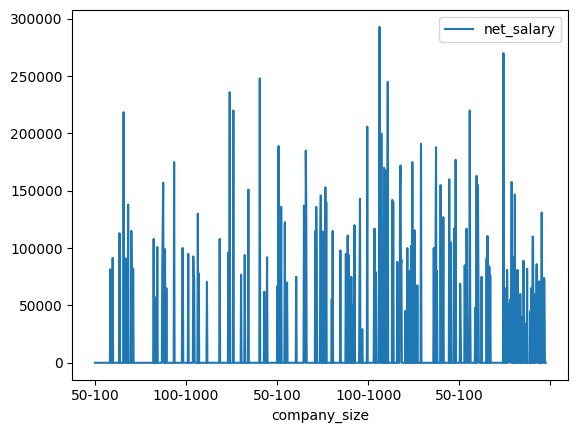

In [270]:
cleaneddf_2019.plot(x='company_size', y='net_salary')

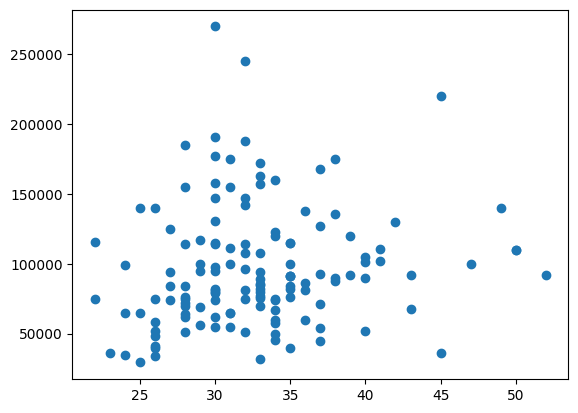

In [271]:
cleaneddf_2019.replace(0, np.nan, inplace=True)
plt.scatter(cleaneddf_2019['age'], cleaneddf_2019['net_salary'])

In [272]:
cleaneddf_2018.to_csv('D:\proG\proggg\cleaneddf2018.csv', index=False)
cleaneddf_2019.to_csv('D:\proG\proggg\cleaneddf2019.csv', index=False)
cleaneddf_2020.to_csv('D:\proG\proggg\cleaneddf2020.csv', index=False)

<>:1: DeprecationWarning: invalid escape sequence '\p'


In [273]:
k = trunc_nan(df2018)
l = cleand(k)
x = cleand_last_yr(l)
prepareddf_2018 = clean_colum(x)
prepareddf_2018 = clean_columns(prepareddf_2018, case='snake', replace={
    'current_salary':'net_salary',
    'salary_one_year_ago':'salary_last_year',
    'position_without_seniority':'position'
})

12 column names have been cleaned

2 column names have been cleaned

In [274]:
h = trunc_nan(df2019)
o = cleand_last_yr(h)
n = cleand(o)
prepareddf_2019 = clean_colum(n)
prepareddf_2019.drop(['yearly_brutto_salary_without_bonus_and_stocks',
                      'yearly_bonus',
                      'yearly_brutto_salary_without_bonus_and_stocks_one_year_ago_only_answer_if_staying_in_same_country',
                      'yearly_bonus_one_year_ago_only_answer_if_staying_in_same_country',
                      'yearly_stocks',
                      'yearly_stocks_one_year_ago_only_answer_if_staying_in_same_country',
                      'number_of_home_office_days_per_month'],
                      axis=1, inplace=True)
prepareddf_2019 = clean_columns(prepareddf_2019, case='snake', replace={
    'position_without_seniority':'position',
    'your_main_technology_programming_language':'main_technology'
    
})

19 column names have been cleaned

2 column names have been cleaned

In [275]:
p = trunc_nan(df2020)
m = cleand_last_yr(p)
l = cleand(m)
prepareddf_2020 = clean_colum(l)
prepareddf_2020.drop([
    'yearly_brutto_salary_without_bonus_and_stocks_in_eur',
    'yearly_bonus_stocks_in_eur',
    'annual_brutto_salary_without_bonus_and_stocks_one_year_ago_only_answer_if_staying_in_the_same_country',
    'annual_bonus_stocks_one_year_ago_only_answer_if_staying_in_same_country'
], axis=1, inplace=True)
prepareddf_2020 = clean_columns(prepareddf_2020, case='snake', replace={
    'position_without_seniority':'position',
    'your_main_technology_programming_language':'main_technology'
})

17 column names have been cleaned

1 column names have been cleaned

In [276]:
prepareddf_2018.loc[prepareddf_2018['position'].str.contains('Java|C#|entwickler|C++|Python|PHP|Backend|.NET|software|erlang|ruby', case=False, na=False), 'position'] = 'Software Engineer'
prepareddf_2018.loc[prepareddf_2018['position'].str.contains('Front|javascript', case=False, na=False), 'position'] = 'Frontend Developer'
prepareddf_2018.loc[prepareddf_2018['position'].str.contains('QA|test|quality', case=False, na=False), 'position'] = 'QA'
prepareddf_2018.loc[prepareddf_2018['position'].str.contains('Machine|ML|learning', case=False, na=False), 'position'] = 'Machine Learning Engineer'
prepareddf_2018.loc[prepareddf_2018['position'].str.contains('DevOps', case=False, na=False), 'position'] = 'DevOps'
prepareddf_2018.loc[prepareddf_2018['position'].str.contains('embedded|hardware|low', case=False, na=False), 'position'] = 'Hardware Engineer'
prepareddf_2018.loc[prepareddf_2018['position'].str.contains('designer|UI|UX', case=False, na=False), 'position'] = 'Designer'
prepareddf_2018.loc[prepareddf_2018['position'].str.contains('quant|science|scientist', case=False, na=False), 'position'] = 'Data Scientist'
prepareddf_2018.loc[prepareddf_2018['position'].str.contains('IOS|Swift', case=False, na=False), 'position'] = 'IOS Developer'
prepareddf_2018.loc[prepareddf_2018['position'].str.contains('business|SAP', case=False, na=False), 'position'] = 'Business Analyst'
prepareddf_2018

,timestamp,age,gender,city,position,experience,seniority_level,net_salary,salary_last_year,main_language,company_size,company_type
0,14/12/2018 12:41:33,43.0,M,München,QA,11.0,Senior,77000.0,76200.0,Deutsch,100-1000,Product
1,14/12/2018 12:42:09,33.0,F,München,Software Engineer,8.0,Senior,65000.0,55000.0,Deutsch,50-100,Product
2,14/12/2018 12:47:36,32.0,M,München,Software Engineer,10.0,Senior,88000.0,73000.0,Deutsch,1000+,Product
3,14/12/2018 12:50:15,25.0,M,München,Frontend Developer,6.0,Senior,78000.0,55000.0,English,1000+,Product
4,14/12/2018 12:50:31,39.0,M,München,Designer,10.0,Senior,69000.0,60000.0,English,100-1000,Ecom retailer
...,...,...,...,...,...,...,...,...,...,...,...,...
760,03/06/2020 20:12:51,40.0,M,Köln,Software Engineer,1.0,Junior,44000.0,40000.0,Deutsch,10-50,Product
761,28/07/2020 04:03:13,0.0,M,Köln,Software Engineer,1.0,Junior,45000.0,40000.0,Deutsch,10-50,Product
762,28/07/2020 04:03:20,0.0,M,Köln,Software Engineer,1.0,Junior,45000.0,40000.0,Deutsch,10-50,Product
763,26/08/2020 09:06:44,0.0,0,0,0,0.0,0,0.0,0.0,0,0,0


Объединяем 3 подготовленных датафрейма, чтобы увеличить объём данных для обучения:

In [277]:
mergeddf = pd.merge(prepareddf_2018, 
        prepareddf_2019, 
        how='outer').merge(prepareddf_2020, how='outer')
mergeddf

C:\Users\динара\AppData\Local\Temp\ipykernel_24796\273204492.py:1: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  mergeddf = pd.merge(prepareddf_2018,
C:\Users\динара\AppData\Local\Temp\ipykernel_24796\273204492.py:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  how='outer').merge(prepareddf_2020, how='outer')


,timestamp,age,gender,city,position,experience,seniority_level,net_salary,salary_last_year,main_language,company_size,company_type,main_technology,company_business_sector,other_technologies,covid_job_loss
0,14/12/2018 12:41:33,43.0,M,München,QA,11.0,Senior,77000.0,76200.0,Deutsch,100-1000,Product,NaN,NaN,NaN,NaN
1,14/12/2018 12:42:09,33.0,F,München,Software Engineer,8.0,Senior,65000.0,55000.0,Deutsch,50-100,Product,NaN,NaN,NaN,NaN
2,14/12/2018 12:47:36,32.0,M,München,Software Engineer,10.0,Senior,88000.0,73000.0,Deutsch,1000+,Product,NaN,NaN,NaN,NaN
3,14/12/2018 12:50:15,25.0,M,München,Frontend Developer,6.0,Senior,78000.0,55000.0,English,1000+,Product,NaN,NaN,NaN,NaN
4,14/12/2018 12:50:31,39.0,M,München,Designer,10.0,Senior,69000.0,60000.0,English,100-1000,Ecom retailer,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3003,18/01/2021 15:05:50,31.0,Male,Berlin,Backend Developer,9,Senior,142000.0,142000.0,English,51-100,Product,Java,NaN,"Python, Javascript / Typescript, Java / Scala,...",Yes
3004,18/01/2021 17:46:02,33.0,Male,Berlin,Researcher/ Consumer Insights Analyst,10,Senior,63000.0,50500.0,English,1000+,Product,consumer analysis,NaN,0,No
3005,18/01/2021 23:20:35,39.0,Male,Munich,Project Manager,15,Lead,110000.0,90000.0,English,101-1000,eCommerce,PHP,NaN,"Python, C/C++, Javascript / Typescript, Java /...",No
3006,19/01/2021 10:17:58,26.0,Male,Saarbrücken,Frontend Developer,7,Middle,79300.0,70200.0,German,101-1000,Product,JavaScript,NaN,"Javascript / Typescript, Docker, HTML, CSS; Ad...",No


In [278]:
genders = {
    'M':'Male',
    'F' : 'Female'
}
for i in genders:
    mergeddf['gender'] = mergeddf['gender'].apply(lambda x:genders.get(i) if (x==i) else x )

mergeddf['gender'] = mergeddf['gender'].fillna('Unknown')
mergeddf['gender'] = mergeddf['gender'].replace(0, 'Unknown')
mergeddf['gender'] = mergeddf['gender'].astype(str)
mergeddf['gender'].unique()

array(['Male', 'Female', 'Unknown', 'Diverse'], dtype=object)

In [279]:
mergeddf['city'].unique()
mergeddf['city'] = mergeddf['city'].fillna('Unknown')
mergeddf['city'] = mergeddf['city'].replace(0, 'Unknown')

cities = {
    'Saint Petersburg ':'Saint-Petersburg',
    'Saint Petersburg':'Saint-Petersburg',
    'saint petersburg':'Saint-Petersburg',
    'Poland':'Warsaw',
    'warsaw':'Warsaw',
    'Kyiv':'Kiev',
    'Krakow, Poland':'Krakow',
    'Krakau':'Krakow',
    'München':'Munich',
    'Riga, Latvia':'Riga',
    'Cracow':'Krakow',
    'Gdańsk':'Gdansk',
    'Warsaw, Poland':'Warsaw',
    'bremen':'Bremen',
    'Nürnberg ':'Nürnberg',
    'Nuremberg':'Nürnberg',
    'Ireland, Dublin':'Dublin'
}

for i in cities:
    mergeddf['city'] = mergeddf['city'].apply(lambda x:cities.get(i) if (x==i) else x )
mergeddf['city'] = mergeddf['city'].astype(str)

In [280]:
mergeddf['city'] = mergeddf['city'].fillna('Unknown')
mergeddf['city'] = mergeddf['city'].replace(0, 'Unknown')
mergeddf['position'].unique()
mergeddf.loc[mergeddf['position'].str.contains('Android', case=False, na=False), 'position'] = 'Android Developer'
mergeddf.loc[mergeddf['position'].str.contains('web', case=False, na=False), 'position'] = 'Web Developer'
mergeddf.loc[mergeddf['position'].str.contains('business', case=False, na=False), 'position'] = 'Business Analyst'
mergeddf.loc[mergeddf['position'].str.contains('recruit|hr', case=False, na=False), 'position'] = 'HR Manager'
mergeddf.loc[mergeddf['position'].str.contains('mobile', case=False, na=False), 'position'] = 'Mobile Developer'
mergeddf['position'] = mergeddf['position'].astype(str)

In [281]:
mergeddf['salary_last_year'].unique()
mergeddf['salary_last_year'].dtype
mergeddf['salary_last_year'] = mergeddf['salary_last_year'].fillna(mergeddf['salary_last_year'].median())
mergeddf['salary_last_year'] = pd.to_numeric(mergeddf['salary_last_year'], errors='coerce')

In [282]:
mergeddf['company_type'] = mergeddf['company_type'].fillna('Unknown')
mergeddf['company_type'] = mergeddf['company_type'].replace(0, 'Unknown')
mergeddf['company_type'] = mergeddf['company_type'].astype(str)
mergeddf.dtypes
mergeddf['company_type'].unique()

array(['Product', 'Ecom retailer', 'Insurance', 'Unknown', 'Startup',
       'Agency', 'Big Tech', 'Consultancy', 'Corporation', 'Outsource',
       'Industry', 'E-Commerce firm', 'Consulting',
       'Internal development for a non-IT company',
       'Personaldienstleister', 'ipo', 'e-commerce',
       'Product and Projects', 'E-Commerce', 'Development',
       'Consulting Company', 'IT Dienstleistungen ', 'Manufacturing',
       'Stock market ', 'telecom operator', 'Ecommerce', 'Outsourcing',
       'Outsorce', 'consulting', 'GmbH', 'IT Consulting ',
       'IT Consultancy ', 'IT Service Provider', 'non-IT, manufacturing',
       'Bank ', 'IT-Beratung', 'Technology Consulting', 'outsource',
       'IT Consultants', 'Hochschule/university', 'ISP', 'Fin Tech',
       'Blockchain technology', 'Retail', 'Consult',
       'Project-based software development', 'Automotive', 'OEM',
       'Consulting (banking)', 'IT Consulting', 'Consulting / Agency',
       'Bodyshop / Outsource', 'Univer

__Предскажем пропущенные значения:__

In [283]:
mergeddf.isna().sum()

timestamp                     0
age                           0
gender                        0
city                          0
position                      0
experience                    0
seniority_level               0
net_salary                    0
salary_last_year              0
main_language                 0
company_size                  0
company_type                  0
main_technology             765
company_business_sector    2017
other_technologies         1756
covid_job_loss             1756
dtype: int64

In [284]:
#cleaneddf_2019.dropna(subset=['net_salary'], inplace=True)
#X = cleaneddf_2019.drop(['timestamp',
#                         'number_of_home_office_days_per_month',
#                         ], axis=1)
#Y = cleaneddf_2019['net_salary']
#mergeddf

In [285]:
mergeddf['net_salary'] = mergeddf['net_salary'].replace(5500000000.00, 55000.00 )
mergeddf['net_salary'] = mergeddf['net_salary'].replace(945000.00, 94500.00 )
mergeddf['net_salary'] = mergeddf['net_salary'].replace(774000.00, 77400.00 )
mergeddf['net_salary'] = mergeddf['net_salary'].replace(700000.00, 70000.00 ) 
mergeddf['net_salary'] = mergeddf['net_salary'].replace(400000.00, 40000.00 )
mergeddf['net_salary'] = mergeddf['net_salary'].replace(700000.00, 70000.00 ) 

Хэшируем категориальные фичи с помощью OneHotEncoder

In [286]:
mergeddf['company_size'] = mergeddf['company_size'].str.replace('\D', '', regex=True)
mergeddf['company_size'].unique()

<>:1: DeprecationWarning: invalid escape sequence '\D'


array(['1001000', '50100', '1000', '1050', '10', nan, '51100', '1011000',
       '1150'], dtype=object)

In [287]:
comp_size = {
    '1001000':'100',
    '50100':'50',
    '1050':'10',
    '51100':'50',
    '1011000':'100',
    '1150':'10'
}

for i in comp_size:
    mergeddf['company_size'] = mergeddf['company_size'].apply(lambda x:comp_size.get(i) if (x==i) else x )
mergeddf['company_size'] = pd.to_numeric(mergeddf['company_size'])
mergeddf['company_size'] = mergeddf['company_size'].fillna(mergeddf['company_size'].median())
mergeddf['company_size'].unique()

array([ 100.,   50., 1000.,   10.])

In [288]:
experience_level = {
    '1 (as QA Engineer) / 11 in total':'1',
    '2,5':'2.5',
    '15, thereof 8 as CTO':'15',
    '6 (not as a data scientist, but as a lab scientist)':'6',
    '383':'3',
    'less than year':'0.5',
    '1,5':'1.5',
    'Polish+English':'Polish'
}

for i in experience_level:
    mergeddf['experience'] = mergeddf['experience'].apply(lambda x:experience_level.get(i) if (x==i) else x )

In [289]:
langs = {
    'English and German':'English',
    '50/50':'German',
    'Русский':'Russian',
    'Russian, English':'Russian',
    'both':'German',
    'Deuglisch':'German',
    'English+Deutsch':'English',
    'Team - Russian; Cross-team - English;':'Russian',
    'Polish+English':'Polish',
    'Deutsch/Englisch':'German',
    'Deutsch':'German'
}

for i in langs:
    mergeddf['main_language'] = mergeddf['main_language'].apply(lambda x:langs.get(i) if (x==i) else x )

In [290]:
genders = {
    'M':'Male',
    'F':'Female'
}

for i in genders:
    mergeddf['gender'] = mergeddf['gender'].apply(lambda x:genders.get(i) if (x==i) else x )

In [291]:
mergeddf['experience'] = pd.to_numeric(mergeddf['experience'])
mergeddf['experience'].unique()

array([11. ,  8. , 10. ,  6. ,  5. ,  3. , 18. ,  0. ,  4. , 17. , 19. ,
       15. , 12. ,  2. ,  1. ,  9. ,  7. , 20. ,  7.5, 14. , 13. ,  0.5,
        2.5,  1.5, 16. , 25. , 30. , 38. , 21. ,  4.5, 22. , 24. , 28. ,
       40. , 26. , 23. ,  5.5,  0.8,  6.5, 29. , 27. , 31. ,  3.5])

In [292]:
for i in mergeddf.columns:
    print(
        i,
        '\n',mergeddf[i].unique(),
        '\n','^'*40
    )
mergeddf

timestamp 
 ['14/12/2018 12:41:33' '14/12/2018 12:42:09' '14/12/2018 12:47:36' ...
 '18/01/2021 23:20:35' '19/01/2021 10:17:58' '19/01/2021 12:01:11'] 
 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
age 
 [43. 33. 32. 25. 39. 37.  0. 36. 30. 40. 31. 29. 24. 44. 34. 28. 35. 38.
 27. 41. 26. 22. 42. 52. 50. 49. 23. 21. 48. 45. 60. 47. 46. 51. 54. 20.
 59. 66. 56. 53. 65. 69.] 
 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
gender 
 ['Male' 'Female' 'Unknown' 'Diverse'] 
 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
city 
 ['Munich' 'Berlin' 'Karlsruhe' 'Hamburg' 'Augsburg ' 'Bremen' 'Frankfurt'
 'Unknown' 'Regensburg' 'Lisbon' 'Leipzig' 'Stuttgart' 'Amsterdam'
 'Luxembourg' 'Bern' 'Bonn' 'Köln' 'Baden-Württemberg ' 'Frankonia'
 'Stuttgart ' 'Mannheim ' 'Bayern' 'Tübingen' 'Brno' 'Dresden' 'Krakow'
 'Dublin' 'Eindhoven' 'Amsterdam ' 'Konstanz' 'Dublin ' 'Prague' 'Moscow'
 'Stockholm' 'Belgrade, Serbia' 'Kiev' 'Nürnberg' 'Karlskrona' 'Vienna'
 'London' 'Bitburg' 'Gdansk' 'Warsaw' 'Düsseldorf' 'Ludwigsbu

,timestamp,age,gender,city,position,experience,seniority_level,net_salary,salary_last_year,main_language,company_size,company_type,main_technology,company_business_sector,other_technologies,covid_job_loss
0,14/12/2018 12:41:33,43.0,Male,Munich,QA,11.0,Senior,77000.0,76200.0,German,100.0,Product,NaN,NaN,NaN,NaN
1,14/12/2018 12:42:09,33.0,Female,Munich,Software Engineer,8.0,Senior,65000.0,55000.0,German,50.0,Product,NaN,NaN,NaN,NaN
2,14/12/2018 12:47:36,32.0,Male,Munich,Software Engineer,10.0,Senior,88000.0,73000.0,German,1000.0,Product,NaN,NaN,NaN,NaN
3,14/12/2018 12:50:15,25.0,Male,Munich,Frontend Developer,6.0,Senior,78000.0,55000.0,English,1000.0,Product,NaN,NaN,NaN,NaN
4,14/12/2018 12:50:31,39.0,Male,Munich,Designer,10.0,Senior,69000.0,60000.0,English,100.0,Ecom retailer,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3003,18/01/2021 15:05:50,31.0,Male,Berlin,Backend Developer,9.0,Senior,142000.0,142000.0,English,50.0,Product,Java,NaN,"Python, Javascript / Typescript, Java / Scala,...",Yes
3004,18/01/2021 17:46:02,33.0,Male,Berlin,Researcher/ Consumer Insights Analyst,10.0,Senior,63000.0,50500.0,English,1000.0,Product,consumer analysis,NaN,0,No
3005,18/01/2021 23:20:35,39.0,Male,Munich,Project Manager,15.0,Lead,110000.0,90000.0,English,100.0,eCommerce,PHP,NaN,"Python, C/C++, Javascript / Typescript, Java /...",No
3006,19/01/2021 10:17:58,26.0,Male,Saarbrücken,Frontend Developer,7.0,Middle,79300.0,70200.0,German,100.0,Product,JavaScript,NaN,"Javascript / Typescript, Docker, HTML, CSS; Ad...",No


In [293]:
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = mergeddf[['experience', 'age', 'seniority_level', 'main_language', 'gender', 'position']]
y = mergeddf['net_salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
cat_features = ['seniority_level', 'main_language', 'gender', 'position']
train_pool = cb.Pool(X_train, y_train, cat_features=cat_features)
test_pool = cb.Pool(X_test, y_test, cat_features=cat_features)

params = {
    'iterations': 600,
    'learning_rate': 0.05,
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'use_best_model': True,
    'od_type': 'Iter',
    'od_wait': 20
}

model = cb.CatBoostRegressor(**params)

model.fit(train_pool, eval_set=test_pool, verbose=False)

y_pred = model.predict(X_test)
new_data = pd.DataFrame(data=[[5.0, 18.0, 'Middle', 'French', 'Male', 'QA']], columns=['experience', 'age', 'seniority_level', 'main_language', 'gender', 'position'])
new_data_array = new_data.iloc[:, 0:6].values
y_pred_new = model.predict(new_data)
y_pred_new

array([41383.80746883])

In [294]:
'''
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

# разбиение на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(
    mergeddf[['experience', 'age', 'seniority_level', 'main_language', 'gender']], 
    mergeddf['net_salary'], 
    test_size=0.2, 
    random_state=42
)

# создание модели и обучение на тренировочных данных
model = CatBoostRegressor()
model.fit(X_train, y_train, cat_features=['seniority_level', 'main_language', 'gender'])

# предсказание на тестовых данных
y_pred = model.predict(X_test)

# вывод метрики качества на тестовых данных (например, R2)
print(model.score(X_test, y_test))
'''

"\nfrom catboost import CatBoostRegressor\nfrom sklearn.model_selection import train_test_split\n\n# разбиение на тренировочные и тестовые данные\nX_train, X_test, y_train, y_test = train_test_split(\n    mergeddf[['experience', 'age', 'seniority_level', 'main_language', 'gender']], \n    mergeddf['net_salary'], \n    test_size=0.2, \n    random_state=42\n)\n\n# создание модели и обучение на тренировочных данных\nmodel = CatBoostRegressor()\nmodel.fit(X_train, y_train, cat_features=['seniority_level', 'main_language', 'gender'])\n\n# предсказание на тестовых данных\ny_pred = model.predict(X_test)\n\n# вывод метрики качества на тестовых данных (например, R2)\nprint(model.score(X_test, y_test))\n"

In [295]:
new_data = [[13.0, 30, 'Middle', 'English', 'Male', 'Software Engineer']]

# преобразование категориальных признаков в числовые
new_data_encoded = mergeddf[['experience', 'age', 'seniority_level', 'main_language', 'gender', 'position']].copy()
new_data_encoded.loc[len(new_data_encoded)] = new_data[0]
new_data_encoded['seniority_level'] = new_data_encoded['seniority_level'].astype('category').cat.codes
new_data_encoded['main_language'] = new_data_encoded['main_language'].astype('category').cat.codes
new_data_encoded['gender'] = new_data_encoded['gender'].astype('category').cat.codes

# предсказание заработной платы на новых данных
predicted_salary = model.predict(new_data_encoded.iloc[-1:])

# вывод предсказанной заработной платы
print(predicted_salary[0])

76934.22494560955


In [296]:
import pickle

# сохранение модели в формате pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

# загрузка модели из формата pickle
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

In [2163]:
mergeddf.to_csv('mergeddff_app', index=False)

In [2164]:
from sklearn.preprocessing import LabelEncoder
enc_lang = LabelEncoder()
mergeddf['main_language'] = enc_lang.fit_transform(mergeddf[['main_language']].astype(str))

c:\Users\динара\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [2165]:
from sklearn.preprocessing import OrdinalEncoder
enc_gen = OrdinalEncoder()
mergeddf['gender'] = enc_gen.fit_transform(mergeddf[['gender']].astype(str))
X = pd.DataFrame(data=[['Middle', 15.0, 5, 'Male']], columns=['seniority_level', 'experience', 'main_language', 'gender'])
enc_lang.fit_transform(X['gender'])

array([0])

In [2166]:
mergeddf['main_language']
mergeddf['main_language'].unique()
mergeddf['gender'].unique()

array([2., 1., 3., 0.])

In [2167]:
from category_encoders import OrdinalEncoder
maplist = [{'col':'seniority_level', 'mapping':{0: 0, 'No level': 1, 'Junior': 2, 'Middle': 3, 'Senior': 4, 'Lead': 5}}]
l_enc_pos = OrdinalEncoder(mapping=maplist)
mergeddf['seniority_level'] = l_enc_pos.fit_transform(mergeddf['seniority_level'].astype(str))
X = pd.DataFrame(data=[['Middle', 15.0, 5, 2]], columns=['seniority_level', 'experience', 'main_language', 'gender'])
l_enc_pos.fit_transform(X)

,seniority_level,experience,main_language,gender
0,3,15.00,5,2


In [2168]:
from category_encoders import OrdinalEncoder
maplist = [{'col':'main_language',
            'mapping':
            {0: 0,
            'German': 1, 
            'English': 2, 
            'Russian': 3, 
            'French': 4, 
            'Polish': 5,
            'Spanish': 6, 
            'Italian': 7, 
            'Dutch': 8, 
            'Ukrainian': 9, 
            'Czech': 10
            }}]
lang_encoder = OrdinalEncoder(mapping=maplist)
mergeddf['main_language'] = lang_encoder.fit_transform(mergeddf['main_language'].astype(str))
X = pd.DataFrame(data=[[15.0, 3, 5, 2]], columns=['experience', 'seniority_level', 'main_language', 'gender'])
lang_encoder.fit_transform(X)

,experience,seniority_level,main_language,gender
0,15.00,3,5,2


In [2169]:
from sklearn.linear_model import LinearRegression
X = mergeddf[['seniority_level', 'experience', 'main_language', 'gender']]
Y = mergeddf['net_salary']
linear_reg = LinearRegression()
linear_reg.fit(X, Y)
X

,seniority_level,experience,main_language,gender
0,4.00,11.00,-1.00,2.00
1,4.00,8.00,-1.00,1.00
2,4.00,10.00,-1.00,2.00
3,4.00,6.00,-1.00,2.00
4,4.00,10.00,-1.00,2.00
...,...,...,...,...
3003,4.00,9.00,-1.00,2.00
3004,4.00,10.00,-1.00,2.00
3005,5.00,15.00,-1.00,2.00
3006,3.00,7.00,-1.00,2.00


In [2170]:
y_predict = linear_reg.predict(X)
y_predict

array([ 86127.63540684,  75521.92404025,  84828.96680453, ...,
       101367.43782981,  70887.83298388,  64394.48997232])

In [2171]:
mergeddf['main_language']

0      -1.00
1      -1.00
2      -1.00
3      -1.00
4      -1.00
        ... 
3003   -1.00
3004   -1.00
3005   -1.00
3006   -1.00
3007   -1.00
Name: main_language, Length: 3008, dtype: float64

In [2172]:
from sklearn.preprocessing import LabelEncoder
enc_lang = LabelEncoder()
y = mergeddf['main_language']
y = y.ravel()
y = enc_lang.fit_transform(y.astype(str))


In [2173]:
new_data = pd.DataFrame(data=[[1, 5.0, 7, 1]], columns=['seniority_level', 'experience', 'main_language', 'gender'])
new_data_array = new_data.iloc[:, 0:5].values
y_pred_new = linear_reg.predict(new_data)
y_pred_new


array([41490.53419214])

In [2174]:
from sklearn.metrics import mean_squared_error

X = mergeddf[['seniority_level', 'experience', 'main_language', 'age', 'gender']]
Y = mergeddf['net_salary']
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 Y,
                                                 test_size=0.1,
                                                 random_state=100,
                                                )
mod = CatBoostRegressor()
mod.fit(X_train, y_train)
y_pred = mod.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
accur = mod.score(X_test, y_test)

print("MSE:", mse)
print('SCORE', accur)

Learning rate set to 0.04792
0:	learn: 34614.3063432	total: 4.95ms	remaining: 4.94s
1:	learn: 34297.0550617	total: 7.52ms	remaining: 3.75s
2:	learn: 34026.0335819	total: 10.7ms	remaining: 3.55s
3:	learn: 33757.3342683	total: 14.1ms	remaining: 3.51s
4:	learn: 33526.5671536	total: 16.9ms	remaining: 3.35s
5:	learn: 33284.8394819	total: 19.9ms	remaining: 3.3s
6:	learn: 33082.7408282	total: 23.6ms	remaining: 3.35s
7:	learn: 32875.4348552	total: 26.7ms	remaining: 3.31s
8:	learn: 32705.3973431	total: 28.6ms	remaining: 3.15s
9:	learn: 32537.1216025	total: 29.8ms	remaining: 2.95s
10:	learn: 32388.8961164	total: 31.2ms	remaining: 2.8s
11:	learn: 32226.2088147	total: 32.6ms	remaining: 2.69s
12:	learn: 32095.8346117	total: 34ms	remaining: 2.58s
13:	learn: 31964.3774843	total: 35ms	remaining: 2.47s
14:	learn: 31830.4817748	total: 36.1ms	remaining: 2.37s
15:	learn: 31720.4682447	total: 37.1ms	remaining: 2.28s
16:	learn: 31651.2434719	total: 38.1ms	remaining: 2.2s
17:	learn: 31538.7590845	total: 39.2

Ткперь воспользуемся Cat Boost

In [2175]:
from sklearn.ensemble import RandomForestRegressor

x = mergeddf.loc[:, 'experience'].values.reshape((-1,1))
y = mergeddf.loc[:, 'net_salary'].values
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 Y,
                                                 test_size=0.1,
                                                 random_state=100,
                                                )
reg = RandomForestRegressor()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
accuracy = reg.score(X_test, y_test)
print("Точность модели:", accuracy)

Точность модели: 0.15622748727803082


In [2176]:
from sklearn.linear_model import LinearRegression
mergeddf.dropna(subset=['company_size'], inplace=True)
X = mergeddf[['seniority_level', 'experience', 'main_language', 'age', 'gender']]
Y = mergeddf['net_salary']
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 Y,
                                                 test_size=0.1,
                                                 random_state=100,
                                                )
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pr = linear_reg.predict(X_test)
accuracy = linear_reg.score(X_test, y_test)
print("Точность модели:", accuracy)

Точность модели: 0.15018689699494303


In [2177]:
from sklearn.metrics import mean_squared_error

X = mergeddf[['experience', 'seniority_level', 'main_language', 'age', 'gender']]
Y = mergeddf['net_salary']
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 Y,
                                                 test_size=0.1,
                                                 random_state=100,
                                                )
mod = CatBoostRegressor()
mod.fit(X_train, y_train)
y_pred = mod.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
accur = mod.score(X_test, y_test)

print("MSE:", mse)
print('SCORE', accur)

Learning rate set to 0.04792
0:	learn: 34630.8109712	total: 1.1ms	remaining: 1.1s
1:	learn: 34308.6879823	total: 2.03ms	remaining: 1.01s
2:	learn: 34030.9788801	total: 2.98ms	remaining: 992ms
3:	learn: 33759.8643310	total: 4.15ms	remaining: 1.03s
4:	learn: 33524.7068834	total: 5.21ms	remaining: 1.04s
5:	learn: 33284.3969719	total: 6.24ms	remaining: 1.03s
6:	learn: 33064.7113494	total: 7.24ms	remaining: 1.03s
7:	learn: 32864.3413525	total: 8.23ms	remaining: 1.02s
8:	learn: 32701.0003810	total: 9.23ms	remaining: 1.02s
9:	learn: 32526.5080716	total: 10.1ms	remaining: 1s
10:	learn: 32366.6396580	total: 11.6ms	remaining: 1.04s
11:	learn: 32204.2735517	total: 13.7ms	remaining: 1.13s
12:	learn: 32060.9143495	total: 15.1ms	remaining: 1.14s
13:	learn: 31936.9395231	total: 16.6ms	remaining: 1.17s
14:	learn: 31817.7394201	total: 19.7ms	remaining: 1.29s
15:	learn: 31695.7841714	total: 21ms	remaining: 1.29s
16:	learn: 31611.3021320	total: 22.1ms	remaining: 1.28s
17:	learn: 31517.5263818	total: 23.2

In [2178]:
new_data = pd.DataFrame(data=[[1, 5.0, 7, 28.0, 3]], columns=['seniority_level', 'experience', 'main_language', 'age', 'gender'])
new_data_array = new_data.iloc[:, 0:5].values
y_pred_new = linear_reg.predict(new_data)
y_pred_new

array([52595.78024313])

In [2179]:
mergeddf['net_salary'].to_csv('salary', index=False)
pd.options.display.float_format = '{:.2f}'.format
mergeddf['net_salary'].describe()
print(mergeddf[mergeddf['net_salary']>= 250000.00]['net_salary'])
index = mergeddf.loc[mergeddf['net_salary'] == 283000.00].index[0]

# Вывести найденную строку
row = mergeddf.loc[index]
print(row)

1151   382000.00
1264   263000.00
1390   293000.00
1662   270000.00
2035   320000.00
2249   330000.00
2284   300000.00
2331   300000.00
2487   255000.00
2500   303000.00
2559   255000.00
2713   272000.00
2748   283000.00
Name: net_salary, dtype: float64
timestamp                                    30/11/2020 21:31:01
age                                                        29.00
gender                                                      2.00
city                                                      London
position                                       Software Engineer
experience                                                  9.00
seniority_level                                             4.00
net_salary                                             283000.00
salary_last_year                                            0.00
main_language                                              -1.00
company_size                                             1000.00
company_type                   

In [2180]:
import pickle
data = {"model": mod, "seniority_level": l_enc_pos, "main_language": enc_lang, "gender": enc_gen}
with open('saved_steps.pkl', 'wb') as file:
    pickle.dump(data, file)

In [2181]:
with open('saved_steps.pkl', 'rb') as file:
    data = pickle.load(file)
regressor_loaded = data["model"]
l_enc_pos = data["seniority_level"]
enc_lang = data["main_language"]
enc_gen = data["gender"]

c:\Users\динара\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


ValueError: X has 1 features, but RandomForestRegressor is expecting 5 features as input.

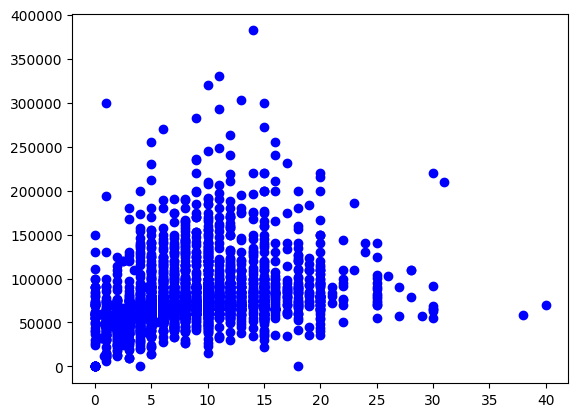

In [2182]:
X_grid = np.arange(min(x), max(x), 0.01)
 
# reshape for reshaping the data
# into a len(X_grid)*1 array,
# i.e. to make a column out of the X_grid value
X_grid = X_grid.reshape((len(X_grid), 1))
 
# Scatter plot for original data
plt.scatter(x, y, color='blue')
 
# plot predicted data
plt.plot(X_grid, reg.predict(X_grid),
         color='green')
plt.title('Random Forest Regression')
plt.xlabel('Lang')
plt.ylabel('Salary')
plt.show()


In [ ]:
col_lst = ['experience', 'main_language', 'net_salary']
mergeddf[col_lst].to_csv('regprobsolv', index=False)

In [ ]:
importances = reg.feature_importances_

# Печать важности параметров
for feature, importance in zip(['main_language', 'net_salary', 'gender', 'experience'], importances):
    print(f"{feature}: {importance}")

main_language: 0.26281880508037336
net_salary: 0.30351435785946085
gender: 0.1022911405460173
experience: 0.28630829208538744


In [ ]:
def get_categorical_indicies(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indicies = []
    for col in cats:
        cat_indicies.append(X.columns.get_loc(col))
    return cat_indicies
categorical_indicies = get_categorical_indicies(X)

def convert_cats(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indicies = []
    for col in cats:
        X[col] = X[col].astype('category')
convert_cats(X)

In [ ]:
print('Test Rate:',y_test.sum()/y_test.count())

In [ ]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = ['gender', 'city', 'position', 'company_type', 'main_technology', 'company_business_sector']

df = mergeddf.drop(['timestamp', 
                    'covid_job_loss',
                    'other_technologies'], axis=1)
label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])
print(df['main_technology'])

# Separate the features (X) and the target variable (y)
X = df.drop('net_salary', axis=1)
y = df['net_salary']

# Train the Linear Regression model
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

# Generate a new instance for prediction
new_instance = {
    'age': [30.0],
    'gender': ['Male'],
    'city': ['Berlin'],
    'position': ['Backend Developer'],
    'experience': [5.0],
    'seniority_level': [4.0],
    'salary_last_year': [65000.0],
    'main_language': [4],
    'company_size': [100],
    'company_type': ['Product'],
    'main_technology': ['Python'],
    'company_business_sector': ['IT'],
}

# Convert the new instance into a DataFrame
new_instance_df = pd.DataFrame(new_instance)

# Perform label encoding for the new instance
for column in categorical_columns:
    new_instance_df[column] = label_encoders[column].transform(new_instance_df[column])

# Make the prediction
prediction = model.predict(new_instance_df)

print("Predicted net salary:", prediction)

TypeError: Encoders require their input to be uniformly strings or numbers. Got ['float', 'int', 'str']